In [204]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

(sec:eda_example)=
# Example: Sale Prices for Houses

In this final section, we carry out an exploratory analysis using the ideas
from this chapter to guide our investigations help us understand the
visualizations that we make. Although EDA typically begins in the data
wrangling stage, for demonstration purposes the data we work with in this
section have already been partially cleaned so that we can focus on exploring
the features of interest. Note also that we will not discuss creating the
visualizations in much detail; that topic is covered in the {ref}`ch:viz`
chapter.

First, we consider the scope of the data (see
{numref}`Chapter %s <ch:data_scope>`
for more on scope).

**Scope.** These data were scraped from the San Francisco Chronicle (SFChron)
Website. The SFChron published weekly data on the sale of houses in the San
Francisco Bay Area.  The data are a census of homes sold during this time. That
is, the population consists of all sales of houses from Apr 2003 to December
2008. Since we are working with a census, the population matches the access
frame and the sample consists of the entire population.


**Granularity.** Each record represents a sale of a home in the SF Bay Area
during the above specified time period.  This means that if a home was sold
twice during this time, then it will have two records in the dataset. And, if a
home in the Bay Area was not sold during this time, then it will not appear in
the dataset.


**File Type.**  When we inspect the data file `sfhousing.csv` with CLI tools
(see Section X), we find that there are over 500,000 rows in the dataset and
that the file indeed consists of comma-separated-values.


In [149]:
# The file has 521494 lines
!wc data/sfhousing.csv

  521494 2801383 47630469 data/sfhousing.csv


In [156]:
# The file is 45M large, which is reasonable to read into pandas
!du -shH data/sfhousing.csv

 45M	data/sfhousing.csv


In [152]:
!head -n 4 data/sfhousing.csv

county,city,zip,street,price,br,lsqft,bsqft,year,date,datesold
Alameda County,Alameda,94501,1001 Post Street,689000,4,4484,1982,1950,2004-08-29,NA
Alameda County,Alameda,94501,1001 Santa Clara Avenue,880000,7,5914,3866,1995,2005-11-06,NA
Alameda County,Alameda,94501,1001 Shoreline Drive \#102,393000,2,39353,1360,1970,2003-09-21,NA


With this, we expect that we can read the file into a DataFrame:

In [195]:
# Some rows in the csv have extra commas, but since there are only a few, we
# drop them when reading in the data.
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)
sfh_all

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


,county,city,zip,street,...,bsqft,year,date,datesold
0,Alameda County,Alameda,94501.00,1001 Post Street,...,1982.00,1950.00,2004-08-29,NaN
1,Alameda County,Alameda,94501.00,1001 Santa Clara Avenue,...,3866.00,1995.00,2005-11-06,NaN
2,Alameda County,Alameda,94501.00,1001 Shoreline Drive \#102,...,1360.00,1970.00,2003-09-21,NaN
3,Alameda County,Alameda,94501.00,1001 Shoreline Drive \#108,...,1360.00,1970.00,2004-09-05,NaN
...,...,...,...,...,...,...,...,...,...
521487,Sonoma County,Windsor,95492.00,9992 Wallace Way,...,1158.00,1993.00,2005-05-15,NaN
521488,Sonoma County,Windsor,95492.00,9998 Blasi Drive,...,NaN,NaN,2008-02-17,NaN
521489,Sonoma County,Windsor,95492.00,9999 Blasi Drive,...,NaN,NaN,2008-02-17,NaN
521490,Sonoma County,Windsor,95492.00,999 Gemini Drive,...,1092.00,1973.00,2003-09-21,NaN


**Feature Types.** This dataset does not have an accompanying codebook, but we
can determine the features and their types by inspection.

In [196]:
sfh_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521491 entries, 0 to 521490
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   county    521491 non-null  object 
 1   city      521491 non-null  object 
 2   zip       521462 non-null  float64
 3   street    521479 non-null  object 
 4   price     521491 non-null  float64
 5   br        421343 non-null  float64
 6   lsqft     435207 non-null  float64
 7   bsqft     444465 non-null  float64
 8   year      433840 non-null  float64
 9   date      521491 non-null  object 
 10  datesold  52102 non-null   object 
dtypes: float64(6), object(5)
memory usage: 43.8+ MB


Based on the names of the fields, we expect the primary key to consist of the
combination of county, city, zip, street address, and date (if the house was
sold more than once in the time period).

Sale price is our focus in this investigation so we begin by examining it.  To
develop your intuition about distributions, make a guess about the shape of the
sale price distribution.


## Understanding Price

A starting guess is that the distribution is highly skewed to the right with a
few expensive houses sold. The summary statistics shown below confirm this
skewness. The median is closer to the lower quartile than to the upper
quartile. Also the maximum is more than 40 times as large as the median.

In [203]:
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

display_df(sfh_all[['price']].describe(), rows=8)

,price
count,521491.00
mean,635443.11
std,393968.53
min,22000.00
25%,410000.00
50%,555000.00
75%,744000.00
max,20000000.00


We might ask whether that \$20m sale price is simply an anomalous value or
whether there are many houses that sold at such a high price. We can zoom in on
the right tail of the distribution and compute a few high percentiles.

In [198]:
percs = [95, 97, 98, 99, 99.5, 99.9]
prices = np.percentile(sfh_all['price'], percs, interpolation='lower')
pd.DataFrame({'price': prices}, index=percs)

,price
95.00,1295000.00
97.00,1508000.00
98.00,1707000.00
99.00,2110000.00
99.50,2600000.00
99.90,3950000.00


We see that $99.9\%$ of the houses sold for under $\$4M$ so the $\$20M$ sale is indeed
a rarity. Let's examine the histogram of sale prices below $\$4M$.
Fewer than 1 in 1,000 sales exceeded $\$4M$. Is the distribution skewed?

<AxesSubplot:xlabel='price', ylabel='Count'>

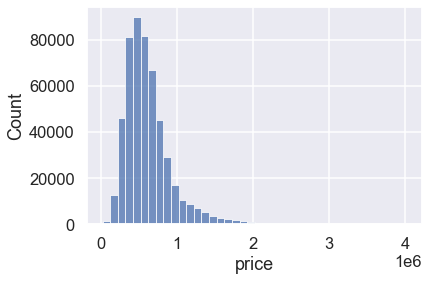

In [199]:
under_4m = sfh_all[sfh_all['price'] < 4_000_000]
sns.histplot(data=under_4m, x='price', binwidth=100000)

We can confirm that the sale price, even without the top 0.1%, remains highly
skewed to the right, with a single mode around \$1m.
Next, we plot the histogram of the logarithm transformed sale price,
which is roughly symmetric:

<AxesSubplot:xlabel='log_price', ylabel='Count'>

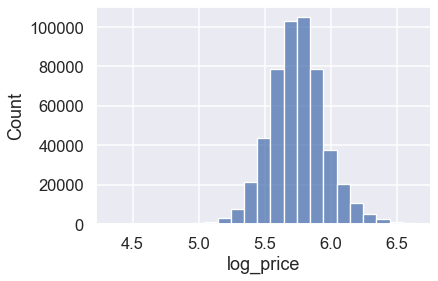

In [200]:
log_prices = under_4m.assign(log_price=np.log10(under_4m['price']))
sns.histplot(data=log_prices, x='log_price', binwidth=0.1)

## What Next?

Now that we have an understanding of the distribution of sale price, let's
consider the so-what questions posed in the previous section. Why might the
data shape matter? Do you have reason to expect that subgroups of the data have
different distributions? What comparison might bring added value to the
investigation?

An initial attempt to answer the first question is that models and statistics
based on symmetric distributions tend to have more robust and stable properties
than for highly skewed distributions. We address this issue more in the
modeling sections of the book. For this reason, we primarily work with the
log-transformed sale price. And, we might also choose to limit our analysis to
sale prices under $6m since the super-expensive houses may behave quite
differently.


To begin to answer the second and third questions, we turn to our knowledge of
the housing market in this time period. Sale prices for houses rose rapidly in
the mid '00s, and then the bottom fell out of the market (Reference).  For this
reason, the distribution of sale price in, say, 2004, might be quite different
than in 2008, right before the crash. To explore this further we can examine
the behavior of prices over time. Or we can fix time, and examine the
relationships between price and the other features of interest, essentially
controlling for a time effect. Both approaches are potentially worthwhile, and
we proceed with both.



Another factor to consider is location. You may have heard the expression:
There are three things that matter in property: *location, location, location.*
Comparing price across cities might bring added value to our investigation.

One approach to EDA is to narrow our focus. In this way we can control for
particular features, such as time. We do this by first limiting the data to
sales made in one calendar year, 2004, so rising prices should have a limited
impact on the distributions and relationships that we examine. To limit the
influence of the very expensive and large houses, we also restrict ourselves to
sales below \$4m and houses smaller than 12,000 ft^2.  This subset  still
contains large and expensive houses, but not outrageously so.   Later, we
further restrict our exploration to a few cities of interest.


In [299]:
def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

sfh = sfh_all.pipe(subset)
sfh

,county,city,zip,street,...,bsqft,year,date,datesold
0,Alameda County,Alameda,94501.00,1001 Post Street,...,1982.00,1950.00,2004-08-29,NaN
1,Alameda County,Alameda,94501.00,1001 Santa Clara Avenue,...,3866.00,1995.00,2005-11-06,NaN
2,Alameda County,Alameda,94501.00,1001 Shoreline Drive \#102,...,1360.00,1970.00,2003-09-21,NaN
...,...,...,...,...,...,...,...,...,...
521484,Sonoma County,Windsor,95492.00,998 Polaris Drive,...,1196.00,1973.00,2007-08-05,NaN
521487,Sonoma County,Windsor,95492.00,9992 Wallace Way,...,1158.00,1993.00,2005-05-15,NaN
521490,Sonoma County,Windsor,95492.00,999 Gemini Drive,...,1092.00,1973.00,2003-09-21,NaN



For this subset, the shape of the distribution of sale price remains the
same---price is still highly skewed to the right. We continue to work with
this subset to address the question: Are there any potentially important
features to create comparisons with/against?


## Examining other features

In addition to the date of the sale and the location of the house, which we
identified earlier, as features of interest, a few other features that might be
important to our investigation are the size of the house, lot (or property)
size, and number of bedrooms. We explore the distributions of these features
and their relationship to sale price.

What might we expect the distributions of building and lot size look like?

Since the size of the property is likely related to its price, it seems
reasonable to guess that these features are also skewed to the right. The cell
below shows the distribution of building size (on the left), and we confirm our
intuition. The distribution is unimodal with a peak at about 1500 ft^2, and
many houses are over 2,500 ft^2 in size. The log-transformed building size is
nearly symmetric, although it maintains a slight skew. The same is the case for
the distribution of lot size.


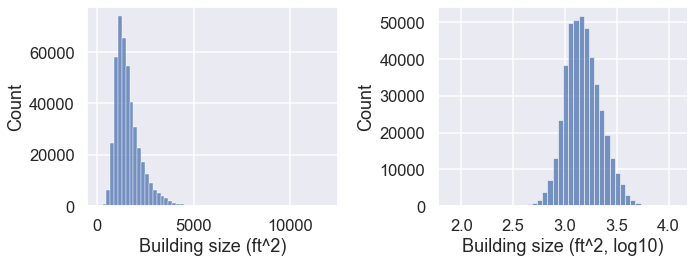

In [264]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

sns.histplot(data=sfh, x='bsqft', binwidth=200, ax=ax1)
ax1.set_xlabel('Building size (ft^2)')

log_bsq = sfh.assign(log_bsqft=np.log10(sfh['bsqft']))
sns.histplot(data=log_bsq, x='log_bsqft', binwidth=0.05, ax=ax2)
ax2.set_xlabel('Building size (ft^2, log10)')

plt.tight_layout()

What might the relationship between building and property size look like?

Given they are both skewed distributions, we will want to plot the points on
log scale. In the next cell, the scatter plot on the left is in the original
units and it is difficult to discern the relationship because of the skewness
of the two distributions. Most of the points are crowded into the bottom left
of the plotting region. The scatterplot on the right reveals a few interesting
features: there is a horizontal line along the bottom of the scatter plot where
it appears that many houses have the same lot size no matter the building size;
and there appears to be a slight positive log-log linear association between
lot and building size.

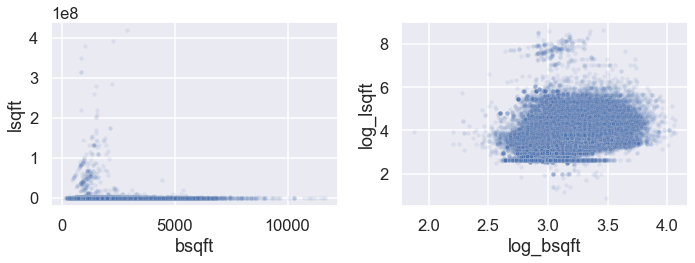

In [265]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

sns.scatterplot(data=sfh, x='bsqft', y='lsqft',
                alpha=0.1, s=20, ax=ax1)

loglog = sfh.assign(log_bsqft=np.log10(sfh['bsqft']), 
                    log_lsqft=np.log10(sfh['lsqft']))
sns.scatterplot(data=loglog, x='log_bsqft', y='log_lsqft',
                alpha=0.1, s=20, ax=ax2)

plt.tight_layout()

Let's look at some lower quantiles of lot size to try and figure out this
value:

In [266]:
percs = [0.5, 1, 1.5, 2, 2.5, 3]
lots = np.percentile(sfh['lsqft'].dropna(), percs, interpolation='lower')
pd.DataFrame({'lot_size': lots}, index=percs)

,lot_size
0.50,436.00
1.00,436.00
1.50,436.00
2.00,612.00
2.50,791.00
3.00,871.00


We found something interesting! About 1.5% of the houses have a lot size of 436
ft^2. What does 436 mean? This is an avenue of investigation worth pursuing
which we've left as an exercise to the reader.

Another measure of house size is the number of bedrooms. Since this is a
discrete quantitative variable, we can treat it as a qualitative feature and
make a bar plot. What do you expect this distribution to look like?


Houses in the Bay Area tend to be on the smaller side so we venture to guess
that the distribution will have a peak at three and skewed to the right with a
few houses having 5 or 6 bedrooms.

In the following cell, the bar plot confirms that we generally had
the right idea. However, we find that there are some houses with as many as 60
bedrooms!

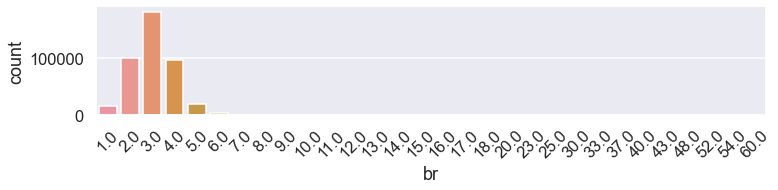

In [282]:
plt.figure(figsize=(12, 2))
sns.countplot(data=sfh, x='br')
plt.xticks(rotation=45);


We transform the number of bedrooms into an ordinal feature by
reassigning all values larger than 8 to 8+, and recreate the bar plot for the
transformed data. We can see that even lumping all of the houses
together with 8+ bedrooms, they do not amount to many. With this
transformation, the rest of the distribution is easier to see. The distribution
is nearly symmetric with a peak at 3, nearly the same proportion of houses have
2 or 4 bedrooms, and nearly the same have 1 or 5. There is asymmetry present
with a few houses having 6 or more bedrooms.

<AxesSubplot:xlabel='br', ylabel='count'>

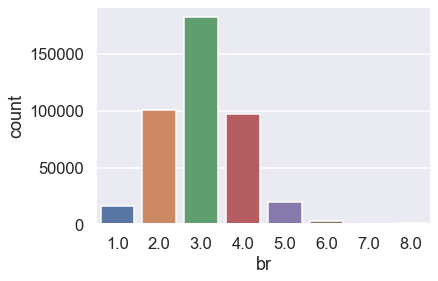

In [298]:
eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
new_bed = sfh['br'].replace(eight_up, 8)
sns.countplot(data=sfh.assign(br=new_bed), x='br')


In EDA, we should also investigate relationships between features and explore
relationships between pairs of variables for different subgroups. As mentioned
in the {ref}`ch:eda_guidelines` section, we examine the distribution of a
feature across subgroups to look for unusual observations in pairs of features
and within subgroups. For example, we found the unusual value of 436 ft^2 for
lot size, and saw that this small lot size appeared for many building sizes.

Before we proceed, we'll save the transformations done thus far into `sfh`.

In [302]:
def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)
       
sfh

,county,city,zip,street,...,datesold,log_price,log_bsqft,log_lsqft
0,Alameda County,Alameda,94501.00,1001 Post Street,...,NaN,5.84,3.30,3.65
1,Alameda County,Alameda,94501.00,1001 Santa Clara Avenue,...,NaN,5.94,3.59,3.77
2,Alameda County,Alameda,94501.00,1001 Shoreline Drive \#102,...,NaN,5.59,3.13,4.59
...,...,...,...,...,...,...,...,...,...
521484,Sonoma County,Windsor,95492.00,998 Polaris Drive,...,NaN,5.54,3.08,3.91
521487,Sonoma County,Windsor,95492.00,9992 Wallace Way,...,NaN,5.64,3.06,3.79
521490,Sonoma County,Windsor,95492.00,999 Gemini Drive,...,NaN,5.51,3.04,3.89


## Delving Deeper into Relationships

We begin by examining how the distribution of price changes for houses with
different numbers of bedrooms. The box plot in the following cell
shows that the median sale price increases with the number of bedrooms from 1
to 5 bedrooms, and for the largest houses (those with 6, 7, and 8+ bedrooms),
there is nearly the same distribution of log-transformed sale price.

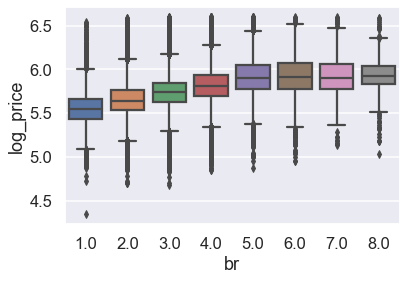

In [304]:
sns.boxplot(data=sfh, x='br', y='log_price');

We would expect that houses with one bedroom are smaller than houses with, say,
4 bedrooms. We might also guess that houses with 6 or more bedrooms are similar
in size. To dive deeper, we consider the normalization (a kind of
transformation) that divides price by building size to give us the price per
square foot. Is this constant for all houses, in other words, is price
primarily determined by its size and does the relationship between size and
price stay the same across different sizes of house?

The following cell creates two scatter plots. The one on the left shows price
against the building size (both log-transformed), and the plot on the right
shows price per square foot (log-transformed) against building size and colors
the points according to the number of bedrooms in the house. In addition, each
plot has an added smooth curve that reflects the local average price or price
per square foot) for buildings of roughly the same size. What do you see?

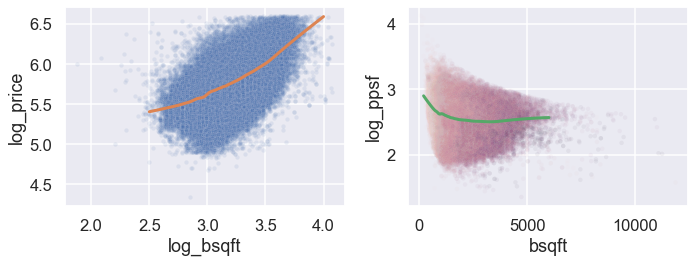

In [331]:
from statsmodels.nonparametric.smoothers_lowess import lowess
color1 = sns.color_palette()[1]
color2 = sns.color_palette()[2]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

sns.scatterplot(data=sfh, x='log_bsqft', y='log_price',
                alpha=0.1, s=20, ax=ax1)
xs = np.linspace(2.5, 4, 100)
curve = lowess(sfh['log_price'], sfh['log_bsqft'], frac=1/10,
               xvals=xs, return_sorted=False)
ax1.plot(xs, curve, color=color1, linewidth=3)

ppsf = sfh.assign(
    ppsf=sfh['price'] / sfh['bsqft'], 
    log_ppsf=lambda df: np.log10(df['ppsf']))
sns.scatterplot(data=ppsf, x='bsqft', y='log_ppsf',
                hue='br', legend=False,
                alpha=0.05, s=20, ax=ax2)
xs = np.linspace(200, 6_000, 100)
curve = lowess(ppsf['log_ppsf'], ppsf['bsqft'], frac=1/10,
               xvals=xs, return_sorted=False)
ax2.plot(xs, curve, color=color2, linewidth=3)

plt.tight_layout()

The lefthand plot shows what we expect---larger houses cost more. We also see
that there is roughly a log-log-linear association.

The righthand plot in this figure is interestingly nonlinear. We see that
smaller houses cost more per square foot than larger ones, and the price per
square foot for larger houses (houses with many bedrooms) is relatively flat.

We mentioned earlier that we also want to consider location. There are house
sales from over 150 different cities in this dataset. Some cities have a
handful of sales and others have thousands. We narrow down the the dataset
further and examine relationships for a few cities.

Before we proceed, we'll save the price per square foot transforms into `sfh`:

In [333]:
def compute_ppsf(sfh):
    return sfh.assign(
    ppsf=sfh['price'] / sfh['bsqft'], 
    log_ppsf=lambda df: np.log10(df['ppsf']))

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
 .pipe(compute_ppsf)
)

sfh.head(2)

,county,city,zip,street,...,log_bsqft,log_lsqft,ppsf,log_ppsf
0,Alameda County,Alameda,94501.00,1001 Post Street,...,3.30,3.65,347.63,2.54
1,Alameda County,Alameda,94501.00,1001 Santa Clara Avenue,...,3.59,3.77,227.63,2.36


## Fixing Time and Location

We examine data for some cities in the East Bay: Richmond, El Cerrito, Albany,
Berkeley, Walnut Creek, Lamorinda (which is a combination of Lafayette, Moraga,
and Orinda, three neighboring bedroom communities), and Piedmont.
We start by combining cities to create Lamorinda:

In [358]:
def make_lamorinda(sfh):
    return sfh.replace({
        'city': {
            'Lafayette': 'Lamorinda',
            'Moraga': 'Lamorinda',
            'Orinda': 'Lamorinda',
        }
    })

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
 .pipe(compute_ppsf)
 .pipe(make_lamorinda)
)
sfh.head(2)

,county,city,zip,street,...,log_bsqft,log_lsqft,ppsf,log_ppsf
0,Alameda County,Alameda,94501.00,1001 Post Street,...,3.30,3.65,347.63,2.54
1,Alameda County,Alameda,94501.00,1001 Santa Clara Avenue,...,3.59,3.77,227.63,2.36


The following box plot of log sale price for these cities shows that Lamorinda
and Piedmont tend to have more expensive homes and Richmond has the least
expensive, but there is overlap in sale price for all areas.


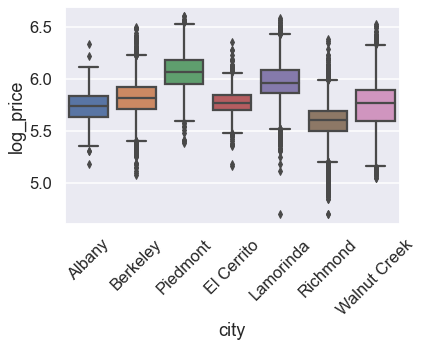

In [360]:
cities = ['Richmond', 'El Cerrito', 'Albany', 'Berkeley',
          'Walnut Creek', 'Lamorinda', 'Piedmont']

sns.boxplot(data=sfh.query('city in @cities'),
            x='city', y='log_price')

plt.xticks(rotation=45);

Next, we'll make a plot showing the log price per ft^2 against the building
size. How does this plot help you think about the importance of location to
home value?

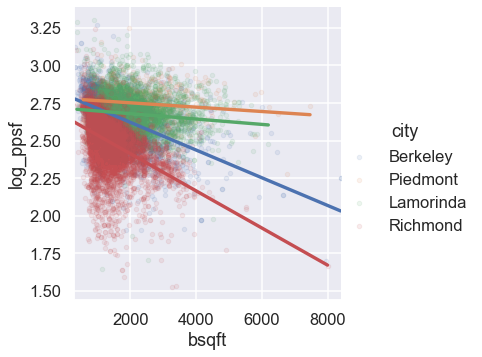

In [376]:
four_cities = ['Berkeley', 'Lamorinda', 'Piedmont', 'Richmond']
sns.lmplot(data=sfh.query('city in @four_cities'),
           x='bsqft', y='log_ppsf', hue='city',
           scatter_kws={'s': 20, 'alpha': 0.1},
           ci=False);

The relationship between price per square foot and building size is roughly
log-linear with a negative association for each of the four locations. While,
not parallel, it does appear that there is a "location" boost for houses,
regardless of size, where, say, a house in Berkeley costs about \$250 more per
square foot than a house in Richmond.  We also see that Piedmont and Lamorinda
are more expensive cities, and in both cities, there is not the same reduction
in price per square foot for larger houses in comparison to smaller ones.

In EDA, we often revisit earlier plots to check whether new findings add
insights in previous settings.  We will keep our EDA brief, and next consider
the time element.

## Changes Over Time

For our final exploration, we return to the full dataset with all sales and
examine price over time. With time, we often make line plots to examine typical
change in price over time.  Since our earlier explorations showed us that price
is a highly skewed distribution, we will want to work with percentiles, rather
than averages. And, since we would like to compare the trends in time for
different priced houses, we make line plots for the 10th, 30th, 50th, 70th, and
90th percentiles in sale price. These line plots are relative to the price in
April 2003 so they all begin at 1. (A value of 1.5 for the 90th percentile in
2006 indicates a sale price that is 1.5 times the 90th percentile in April,
2003.)

In [403]:
def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(date=dates).set_index('date')

percs = [10, 30, 50, 70, 90]

def find_percentiles(series):
    prices = np.percentile(series, percs, interpolation='lower')
    return pd.Series(prices, index=percs)

monthly_percentiles = (sfh_all
 .pipe(parse_dates)
 .resample('M')
 ['price']
 .apply(find_percentiles)
 .reset_index()
 .rename(columns={'level_1': 'percentile'})
)
monthly_percentiles

,date,percentile,price
0,2003-04-30,10,255000.00
1,2003-04-30,30,340000.00
2,2003-04-30,50,421000.00
...,...,...,...
337,2008-11-30,50,365000.00
338,2008-11-30,70,515000.00
339,2008-11-30,90,841500.00


In [406]:
rel_prices = (monthly_percentiles
 .groupby('percentile')
 ['price']
 .transform(lambda s: s / s.iloc[0])
)

rel_percentiles = monthly_percentiles.assign(rel_price=rel_prices)
rel_percentiles

,date,percentile,price,rel_price
0,2003-04-30,10,255000.00,1.00
1,2003-04-30,30,340000.00,1.00
2,2003-04-30,50,421000.00,1.00
...,...,...,...,...
337,2008-11-30,50,365000.00,0.87
338,2008-11-30,70,515000.00,0.96
339,2008-11-30,90,841500.00,1.07


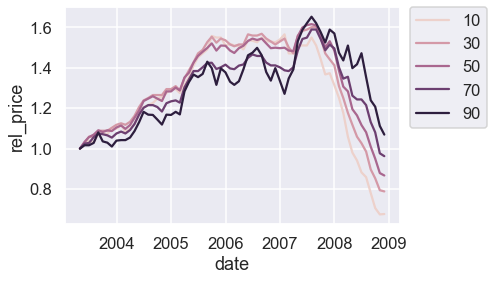

In [419]:
sns.lineplot(data=rel_percentiles,
             x='date', y='rel_price', hue='percentile')
plt.legend(bbox_to_anchor=(1.03, 1), borderaxespad=0);

What do you notice?

When we follow the 10th percentile line plot over time, we see that it
increases quickly in 2005, stays high relative to its 2003 value for a few
years, and then drops earlier and faster than the other line plots. The less
expensive houses, such as starter homes, suffered greater volatility and lost
much more value in the housing market crash. To make the analysis more
thorough, we would want to adjust price for inflation and see how that impacts
the trend in time.

## What have we discovered?

Our EDA has uncovered several interesting phenomenon. Briefly, some that are
most notable are:

- Sale price and building size are highly skewed to the right with one mode.
- Price per square foot decreases nonlinearly with building size, with smaller
  houses costing more per square foot than larger houses, and the price per
  square foot being roughly constant for houses with three or more bedrooms.
- More desirable locations add a bump in sale price that is roughly the same
  size for houses of different sizes.
- Over time, the rise and crash of house prices was more dramatic, rising more
  quickly, falling faster, and falling well below the 2003 value, for houses in
  the lower 10 to 30 percentiles of the market.


There are many additional explorations we can perform, and there are several
checks that we should make. These include: investigating the 436 value for lot
size;  adjusting sale price for inflation; and crosschecking unusual houses,
like the 15 bedroom house and the $20m house, with online real estate apps.
Despite being brief, this section conveys the basic approach of
EDA in action. For an extended case study on a different dataset, see
the {ref}`ch:pa` chapter.